In [7]:
import torch.utils.data as data

from util import *
from transforms import *
from modnet import MODNet
seed = 2002 

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


import matplotlib.pyplot as plt 


class MattingTransform:
    def __init__(self):
        
        self.matting_transform = {
            "train" : ComposeTrain(),
            "validation" : ComposeValidation()
        }
    def __call__(self, phase, data):
        return self.matting_transform[phase](data)

class MattingDataset(data.Dataset):
    def __init__(self, datasets, phase, transform):
        self.datasets = datasets
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.datasets)
    
    def __getitem__(self, index):
        image ,alpha = self.datasets[index]
        image ,alpha, trimap = self.transform(self.phase, [image ,alpha])
        return image, alpha,trimap 
    
def plot_images(boundaries, trimap, alpha, gt_detail):

    plt.figure(figsize=(16, 4))  # Điều chỉnh chiều rộng (16) và chiều cao (4) tùy ý

    # Vẽ hình ảnh đầu tiên (boundaries)
    plt.subplot(1, 4, 1)  # 1 hàng, 4 cột, vị trí 1
    plt.imshow(np.transpose(boundaries, (1, 2, 0)), cmap='gray')
    plt.title('Boundaries')

    # Vẽ hình ảnh thứ hai (trimaps)
    plt.subplot(1, 4, 2)  # 1 hàng, 4 cột, vị trí 2
    plt.imshow(np.transpose(trimap, (1, 2, 0)), cmap='gray')
    plt.title('Trimaps')

    # Vẽ hình ảnh thứ ba (alpha)
    plt.subplot(1, 4, 3)  # 1 hàng, 4 cột, vị trí 3
    plt.imshow(np.transpose(alpha, (1, 2, 0)), cmap='gray')
    plt.title('Alpha')

    # Vẽ hình ảnh thứ tư (gt_detail)
    plt.subplot(1, 4, 4)  # 1 hàng, 4 cột, vị trí 4
    plt.imshow(np.transpose(gt_detail, (1, 2, 0)), cmap='gray')
    plt.title('GT Detail')

    plt.show()

import scipy
from scipy.ndimage import grey_dilation, grey_erosion
import math
from torch import nn
class GaussianBlurLayer(nn.Module):
    """ Add Gaussian Blur to a 4D tensors
    This layer takes a 4D tensor of {N, C, H, W} as input.
    The Gaussian blur will be performed in given channel number (C) splitly.
    """

    def __init__(self, channels, kernel_size):
        """ 
        Arguments:
            channels (int): Channel for input tensor
            kernel_size (int): Size of the kernel used in blurring
        """

        super(GaussianBlurLayer, self).__init__()
        self.channels = channels
        self.kernel_size = kernel_size
        assert self.kernel_size % 2 != 0

        self.op = nn.Sequential(
            nn.ReflectionPad2d(math.floor(self.kernel_size / 2)), 
            nn.Conv2d(channels, channels, self.kernel_size, 
                      stride=1, padding=0, bias=None, groups=channels)
        )

        self._init_kernel()

    def forward(self, x):
        """
        Arguments:
            x (torch.Tensor): input 4D tensor
        Returns:
            torch.Tensor: Blurred version of the input 
        """

        if not len(list(x.shape)) == 4:
            print('\'GaussianBlurLayer\' requires a 4D tensor as input\n')
            exit()
        elif not x.shape[1] == self.channels:
            print('In \'GaussianBlurLayer\', the required channel ({0}) is'
                  'not the same as input ({1})\n'.format(self.channels, x.shape[1]))
            exit()
            
        return self.op(x)
    
    def _init_kernel(self):
        sigma = 0.3 * ((self.kernel_size - 1) * 0.5 - 1) + 0.8

        n = np.zeros((self.kernel_size, self.kernel_size))
        i = math.floor(self.kernel_size / 2)
        n[i, i] = 1
        kernel = scipy.ndimage.gaussian_filter(n, sigma)

        for name, param in self.named_parameters():
            param.data.copy_(torch.from_numpy(kernel))

    
if __name__ == '__main__' :
    val500np_paths = generate_paths_for_dataset('VAL500NP') # => [image_path, mask_path]
    val500np_dataset = MattingDataset(datasets = val500np_paths, phase= 'validation', transform= MattingTransform())
        

    batch_size = 1
    val500np_dataloader = data.DataLoader(val500np_dataset, batch_size= batch_size, shuffle= True)
    
    dataload_dir = {
        "val500np" : val500np_dataloader,
    }
    batch_iterator = iter(dataload_dir['val500np'])
    images, alphas,trimaps = next(batch_iterator)
    boundaries = (trimaps < 0.5) + (trimaps > 0.5)
    gt_detail = torch.where(boundaries, trimaps, alphas)

    modnet = MODNet()
    pred_semantic, pred_detail, pred_matte = modnet(images, False)
    blurer = GaussianBlurLayer(1, 3)
    pred_boundary_detail = torch.where(boundaries, trimaps, pred_detail)
    gt_detail = torch.where(boundaries, trimaps, alphas)    

In [13]:
print(boundaries.shape)
print(trimaps.shape)
print(alphas.shape)
print(pred_boundary_detail.shape)

torch.Size([1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


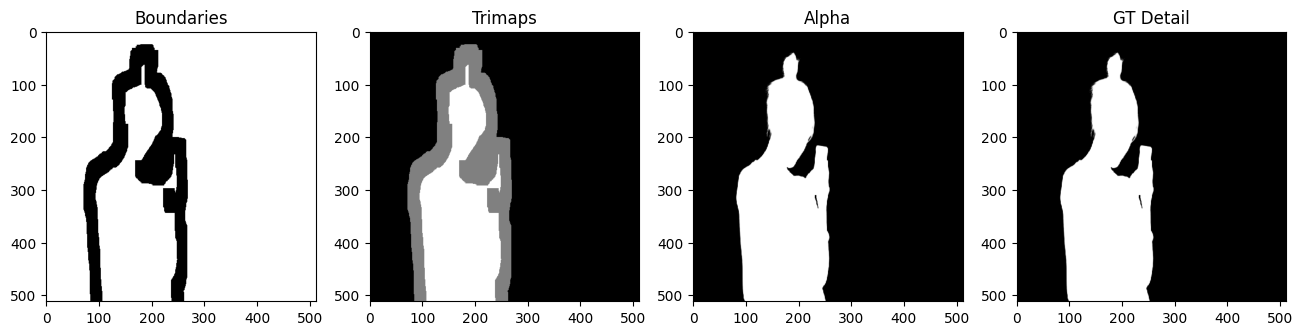

In [20]:
plot_images(boundaries, trimaps[0], alphas[0], gt_detail[0].detach().numpy())

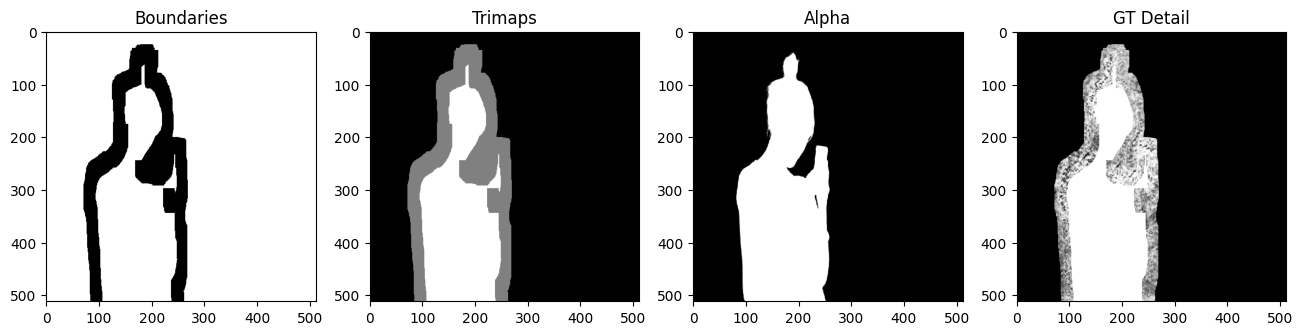

In [19]:
plot_images(boundaries, trimaps[0], alphas[0], pred_boundary_detail[0].detach().numpy())

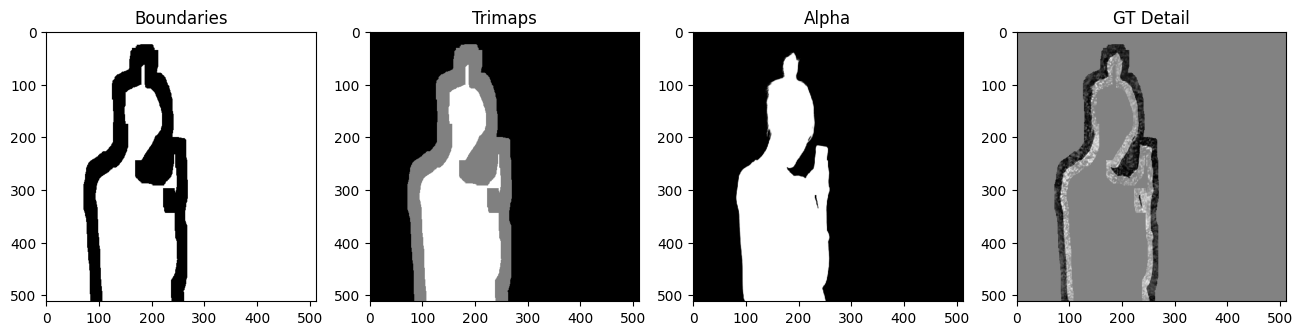

In [23]:
test = gt_detail[0].detach().numpy() - pred_boundary_detail[0].detach().numpy()
plot_images(boundaries, gt_detail[0].detach().numpy(), pred_boundary_detail[0].detach().numpy(), test)